This notebook calculates the angular power spectra for the intrinsic alignment halo model using the Simpson's integration method with enough sampling points to get a very high accuracy on the computation of the Fourier transform of the intrinsic satellite shear profile. It serves as a test for the accuracy of the FFTLog-based results which are obtained much faster than the Simpsons method.

In [1]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt

# Preliminaries
First we generate the cosmology, the wavenumber $k$ and scale factor $a$ arrays. The arrays are used for computing the power spectrum, $P(k,a)$.

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

k_arr = np.geomspace(1E-3, 1e3, 256)  # For evaluating
a_arr = np.linspace(0.1, 1, 32)

We also need to initialize halo model quantities. These are:
 - A halo mass definition.
 - A concentration-mass relation.
 - A halo mass function.
 - A halo bias function.
 - A halo model calculator object that will take care of the various integrals.

In [3]:
# Here we use a mass definition with Delta = 200 times the matter density,
hmd_200m = ccl.halos.MassDef200m()

# the Duffy 2008 concentration-mass relation,
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)

# the Tinker 2008 halo mass function,
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)

# the Tinker 2010 halo bias,
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)

# and the halo model calculator object.
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m)

Define the satellite shear HODs:
- One doing the FFTLog integration.
- One doing the Simpson's with high sampling (taken as the fiducial).

In [4]:
sat_gamma_HOD_simps = ccl.halos.SatelliteShearHOD(concentration=cM, integration_method='simpson')
sat_gamma_HOD_simps.update_parameters(N_r=2048)

Here I show that the intrinsic shear field integrated with a Simpson's method using 2048 points is roughly the same as that with 4096 points even for a halo of mass with $10^{15}$ M$_\odot$. We can conclude that at 2048 points the integration has converged sufficiently to the analytical solution. The convergence is faster for lower masses.

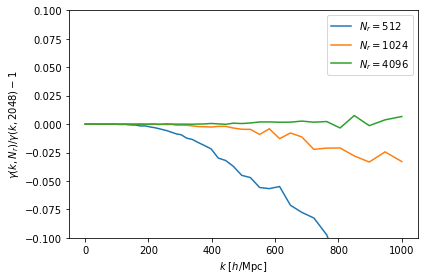

In [5]:
mass = 1e15 # Msun
a = 1.
# Fiducial gamma(k) with 2048 sampling points for integration.
gammak0 = sat_gamma_HOD_simps._usat_fourier(cosmo, k_arr, mass, a)

fig, ax = plt.subplots()

for Nrpoints in [512, 1024, 4096]:
    sat_gamma_HOD_simps.update_parameters(N_r=Nrpoints)
    gammak = sat_gamma_HOD_simps._usat_fourier(cosmo, k_arr, mass, a)
    ax.plot(k_arr, gammak0/gammak-1, label='$N_r=%i$'%Nrpoints)
ax.set_ylim([-0.1,0.1])
ax.set_xlabel('$k$ [$h$/Mpc]')
ax.set_ylabel('$\gamma(k,N_r)/\gamma(k,2048)-1$')
ax.legend()

fig.tight_layout()

# Set back to 2048
sat_gamma_HOD_simps.update_parameters(N_r=2048)

Now I construct the Pk2D objects for GI and II correlations using the Simpson's method. These will be used to compute angular power spectra.

In [6]:
%%time
# NFW profile for matter
NFW =  ccl.halos.HaloProfileNFW(cM, truncated=True, fourier_analytic=True)

pk_GI_1h_simps = ccl.halos.halomod_Pk2D(cosmo, hmc, NFW,
                                  normprof1=True, normprof2=True,
                                  prof2 = sat_gamma_HOD_simps,
                                  get_2h = False,
                                  lk_arr = np.log(k_arr),
                                  a_arr = a_arr)
pk_II_1h_simps = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD_simps,
                                  normprof1=True, normprof2=True,
                                  get_2h = False,
                                  lk_arr = np.log(k_arr),
                                  a_arr = a_arr)

CPU times: user 3min 55s, sys: 1min 38s, total: 5min 33s
Wall time: 5min 31s


The intrinsic alignment power spectra are higher at lower redshift, and I construct a redshift distribution that peaks at lower redshift to compute the angular power spectra.

Text(0, 0.5, '$n(z)$')

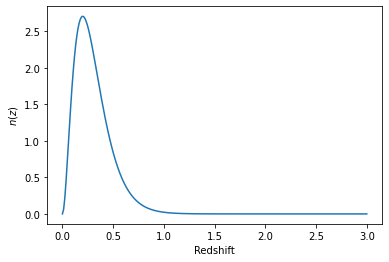

In [7]:
z_arr = np.linspace(0., 3., 256)
z0 = 0.1
pz = 1./(2.*z0) * (z_arr / z0)**2. * np.exp(-z_arr/z0)

plt.plot(z_arr, pz)
plt.xlabel('Redshift')
plt.ylabel('$n(z)$')

In [8]:
# Angular power spectra
b_IA = np.ones(len(z_arr)) # A_IA = 1 in the NLA model
# A tracer without shear and A_IA contribution. The alignment signal is embedded in the power spectrum.
ia_tracer = ccl.WeakLensingTracer(cosmo, dndz = (z_arr, pz), has_shear=False, ia_bias = (z_arr, b_IA), use_A_ia=False)
# A tracer without shear but with A_IA, to compute the NLA-only contribution.
ia_NLA_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz), has_shear=False, ia_bias = (z_arr, b_IA), use_A_ia=True)
# A weak gravitational lensing tracer for the GG and GI terms.
wl_tracer = ccl.WeakLensingTracer(cosmo,dndz = (z_arr, pz))

l_arr = np.unique(np.geomspace(2, 10000, 256).astype(int))

cl_GI_1h_simps = ccl.angular_cl(cosmo, wl_tracer, ia_tracer, l_arr, p_of_k_a = pk_GI_1h_simps)
cl_II_1h_simps = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, l_arr, p_of_k_a = pk_II_1h_simps)
cl_GI_NLA = ccl.angular_cl(cosmo, wl_tracer, ia_NLA_tracer, l_arr)
cl_II_NLA = ccl.angular_cl(cosmo, ia_NLA_tracer, ia_NLA_tracer, l_arr)
cl_GG = ccl.angular_cl(cosmo, wl_tracer, wl_tracer, l_arr)
cl_GI_simps = cl_GI_1h_simps + cl_GI_NLA
cl_II_simps = cl_II_1h_simps + cl_II_NLA

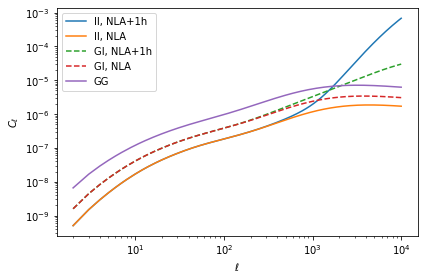

In [9]:
lfac = l_arr * (l_arr + 1) / (2 * np.pi)

fig, ax = plt.subplots(1, 1)
ax.plot(l_arr, lfac * cl_II_simps, label='II, NLA+1h')
ax.plot(l_arr, lfac * cl_II_NLA, label='II, NLA')
ax.plot(l_arr, lfac * -cl_GI_simps, label='GI, NLA+1h', ls='--')
ax.plot(l_arr, lfac * -cl_GI_NLA, label='GI, NLA', ls='--')
ax.plot(l_arr, lfac * cl_GG, label='GG')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel(r'$C_\ell$')
ax.set_xlabel(r'$\ell$')
ax.legend()

fig.tight_layout()
plt.show()

In [10]:
output_data = np.column_stack((l_arr, cl_GI_1h_simps, cl_II_1h_simps))
np.savetxt('../IA_halomodel_Cell_test.txt', output_data, delimiter=',')

Now I test the same calculation using FFTLog as an integration method and compare the two:

In [11]:
l_arr, cl_GI_benchmark, cl_II_benchmark = np.loadtxt(
    '../IA_halomodel_Cell_test.txt', delimiter=',', unpack=True)
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)
k_arr = np.geomspace(1E-3, 1e2, 128)  # For evaluating
a_arr = np.linspace(0.1, 1, 16) # Reduced scale factor sampling for speed

hmd_200m = ccl.halos.MassDef200m()
cM = ccl.halos.ConcentrationDuffy08(hmd_200m)
nM = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200m)
bM = ccl.halos.HaloBiasTinker10(cosmo, mass_def=hmd_200m)
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, hmd_200m, nlog10M=64) # Reduced mass sampling for speed

In [12]:
%%time
sat_gamma_HOD = ccl.halos.SatelliteShearHOD(concentration=cM)
# Tweaking the parameters to get required accuracy:
sat_gamma_HOD.update_precision_fftlog(padding_lo_fftlog=1E-2,
                                      padding_hi_fftlog=1E3,
                                      n_per_decade=350,
                                      plaw_fourier=-3.7)
NFW = ccl.halos.HaloProfileNFW(cM, truncated=True, fourier_analytic=True)

pk_GI_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, NFW,
                                  normprof1=True, normprof2=True,
                                  prof2=sat_gamma_HOD,
                                  get_2h=False,
                                  lk_arr=np.log(k_arr),
                                  a_arr=a_arr)
pk_II_1h = ccl.halos.halomod_Pk2D(cosmo, hmc, sat_gamma_HOD,
                                  normprof1=True, normprof2=True,
                                  get_2h=False,
                                  lk_arr=np.log(k_arr),
                                  a_arr=a_arr)

z_arr = np.linspace(0., 3., 256)
z0 = 0.1
pz = 1. / (2. * z0) * (z_arr / z0) ** 2. * np.exp(-z_arr / z0)

b_IA = np.ones(len(z_arr))
ia_tracer = ccl.WeakLensingTracer(cosmo, dndz=(z_arr, pz), has_shear=False, ia_bias=(z_arr, b_IA), use_A_ia=False)
wl_tracer = ccl.WeakLensingTracer(cosmo, dndz=(z_arr, pz))

cl_GI_1h = ccl.angular_cl(cosmo, wl_tracer, ia_tracer, l_arr, p_of_k_a=pk_GI_1h)
cl_II_1h = ccl.angular_cl(cosmo, ia_tracer, ia_tracer, l_arr, p_of_k_a=pk_II_1h)

CPU times: user 6.83 s, sys: 1.31 s, total: 8.14 s
Wall time: 1.45 s


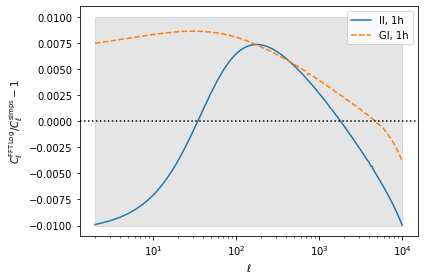

In [13]:
fig, ax = plt.subplots(1, 1)

ax.plot(l_arr, cl_II_1h/cl_II_benchmark-1, label='II, 1h')
ax.plot(l_arr, cl_GI_1h/cl_GI_benchmark-1, label='GI, 1h', ls='--')
ax.fill_between(l_arr, -0.01, 0.01, color='k', alpha=0.1)
ax.axhline(y=0, ls='dotted', c='black')
ax.set_xscale('log')
ax.set_ylabel(r'$C_\ell^\mathrm{FFTLog}/C_\ell^\mathrm{simps}-1$')
ax.set_xlabel(r'$\ell$')
ax.legend()

fig.tight_layout()
plt.show()

assert np.all(np.fabs(cl_GI_1h / cl_GI_benchmark - 1) < 0.0105)
assert np.all(np.fabs(cl_II_1h / cl_II_benchmark - 1) < 0.0105)

This is accurate to about 1% down to $\ell\le10,000$. Higher accuracy can be achieved by tweaking the FFTLog parameters (e.g. number of points per decade, power law index, padding) or increasing sampling in $k$, $a$ and $M$. Note that the relevant scales are $\ell\gtrsim$350, below which the NLA profile is dominant, as seen in the figure above.